Measure Coulomb Blocking by sweeping ST using LF by the SHFQC and Toolkit

**Spectroscopy or Readout mode?**
It appears that while spectroscopy can be used for different parameter sweeps, it is best used for frequency sweeps. Readout mode is more versitile in our case and should be used
...Except for the fact that we cannot pulse LF readout instead it only gives us a square pulse. So we actually need to hack spectroscopy mode in order for it to work

See `rf_st_sweep.ipynb` for code that uses readout and RF mode effectively. This is what we wish we could do :(

This is written based on `shfqc_qd_toolkit_1607.ipynb` and numerous trial and errors

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

import time
from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_22704\652053071.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [4]:
#session.disconnect_device(DEVICE_ID)

In [5]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[5],  # drive SET (ST) line
}

drive_chans = ["ST"]  # match keys above

In [6]:
NUM_READOUTS = 500

## Setup SG Channels

In [7]:
with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(-20)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        #chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

        chan[c].output.on(1)  # enable the channel (rememeber to disable it later)

**Triggers**
To control pulse (and acqusition) timings we must use triggers to "align" different sequencers together.


- *Generation from SeqC code*
For AWGs there are two ways to generate triggers. Either by setting the two marker bits of the waveform, or controlling the triger bits using SeqC code. Using waveforms is more accurate since it runs in 0.5ns time instead of 4ns clock speed of SeqC.

When running `marker(LENGTH, 0b01)` (to set the waveform markers to then use for trigger) we can configure which marker we want to set, out a possibility of 2. These correspond to *Output X Marker Y* where Y is dependent on which marker you set

Whereas running `setTrigger(0b0011)` on an AWG core sets trigger outputs 1,2 high and 3,4 low. These correspond to *AWG Trigger 1-4*

- *Waiting for a trigger*
When running `waitDigTrigger(1)` the SeqC code halts under the specified trigger is found. See "AWG > Trigger" to find what it is currently set as. Use the Internal Trigger (or sometimes the Software trigger). Can also use external triggers if desired (and if we needed additional channels in the future).

There are two possible triggers that you can use. These are known as **auxilary triggers** Set them with `chan["measure"].generator.auxtriggers[1].channel("inttrig")`

See `chan["measure"].generator.available_aux_trigger_inputs` for the possible triggers that you can wait upon.


In [8]:
0b11

3

In [9]:
seq = Sequence()
seq.code = f"""
wave w_a = ones(128);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_a, 0);

repeat({NUM_READOUTS}) {{
    waitDigTrigger(1);

    setTrigger(1);
    setTrigger(0);
    executeTableEntry(0);
       
}}
"""

chan["ST"].awg.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

In [10]:
# setup drive command tables

ct_schema = chan["ST"].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 1.0

ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude11.value = gain
# ct.table[0].waveform.samplingRateDivider = 0  # 2^X divider
#ct.table[0].waveform.length = 10240
#ct.table[0].waveform.playHold = True

chan["ST"].awg.commandtable.upload_to_device(ct)

## Setup QA Channel

**TODO**: I don't know why but when setting `chan["measure"].spectroscopy.result.averages` so many bugs occur. This *should* be the same value as NUM_READOUTS, but that always means that it isn't measured correctly. Keeping it small (like 1 or 5) seems to work...

It's probably fine to leave averages at 1, as we will explicitly define our averages in our sequence. For example, we will run a 2D sweep 100x if we request 100 averages.

In [27]:
with device.set_transaction():
    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    #chan["measure"].output.digitalmixer.centerfreq(400e6)  # only applicable for RF mode (otherwise forced to 0Hz)
    #chan["measure"].centerfreq(0)  # in Hz (appears to be ignored when in LF mode. immutable?)
    chan["measure"].oscs[0].freq(406.6e6)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(0.95)  # If we set this to 1, then output overloads

    # temporarily disabled based on tutorial
    #chan["measure"].generator.auxtriggers[0].channel(8)  # use internal trigger
    #chan["measure"].generator.enable(0)  # do not run yet

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(512)  # integration time length in units of number of samples (usually  integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code

    # setup result parameters
    chan["measure"].spectroscopy.result.averages(5)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(64)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger
    

    #chan["measure"].input.range(0)
    #chan["measure"].output.range(-5)
    #chan["measure"].input.on(1)
    #chan["measure"].output.on(1)

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-20,  # in units of dBm
        output_range=-20,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    # temporarily disable based on tutorial
    #chan["measure"].generator.configure_sequencer_triggering(
    #    aux_trigger=8,  # internal trigger
    #    play_pulse_delay=0,  # 0s delay between startQA trigger and the readout pulse
    #)

In [12]:
chan["measure"].generator.available_aux_trigger_inputs

['chan0trigin0',
 'chan0trigin1',
 'trigin0',
 'trigin1',
 'trigin2',
 'trigin3',
 'trigin4',
 'trigin5',
 'inttrig',
 'chan0seqtrig0',
 '',
 '',
 '',
 '',
 '',
 'awg_marker0',
 'chan0rod',
 'awg_trigger0',
 'awg_trigger1',
 'awg_trigger2',
 'awg_trigger3',
 'awg_trigger4',
 'awg_trigger5',
 'swtrig0']

In [28]:
chan["measure"].generator.auxtriggers[1].channel("inttrig")

In [14]:
# optionally if we want to do pulsed spectroscopy readout use an envelope to shape the QA signal
# unfortunately this cannot be as long as we desire (cannot change QA sampling rate)

#chan["measure"].spectroscopy.envelope.enable(1)  # use pulsed readout
#chan["measure"].spectroscopy.envelope.wave(np.ones(128) * 1j)

In [29]:
chan["measure"].spectroscopy.envelope.wave()

array([0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
       0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j, 0.+1.j,
      

Configure the readout pulse sequence. As we use continuous waves in spectroscopy there is actually never any wave specified to play, as it is always playing.

Instead the `playZero` commands are used so that the trigger spacing is done correctly. `playZero` is non-blocking (the SeqC code will continue after setting it) unless there is a previous `playZero` command that hasn't been fufilled. Using this we can accurately space our triggers (which trigger the spectroscopy readout).

In [30]:
# configure the sequencer for the readout pulses

# Sequencer waits for the trigger, then starts the readout, then repeats this for the chosen number of readouts


chan["measure"].generator.configure_sequencer_triggering(
    aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
    play_pulse_delay=0
)

seq = Sequence()
seq.code = f"""
setTrigger(0);
repeat ({NUM_READOUTS}) {{
    // wait for a digital trigger before starting (defined by the aux_trigger)
    waitDigTrigger(1);

    // delay before readout
    playZero(128+16*3); // time before readout A (224 samples = lines up with SG trigger)
    playZero(64);  // readout time B

    // if using an envelope make sure to open it
    //startQA(QA_GEN_ALL, QA_INT_ALL, true, 0, 0x0);  // also send sequence monitor trigger (true)

    // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(1);
    setTrigger(0);

    playZero(32); // relax time C (just wait for above readout to finish)
}}
"""

chan["measure"].generator.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

In [17]:
# set readout pulses. Not used in spectroscopy mode, only in readout mode
#readout_pulses = Waveforms()
#readout_pulses.assign_waveform(
#    slot=0,
#    wave1=np.ones(128),  # assumes 0 for wave2
#)
#
#chan["measure"].generator.write_to_waveform_memory(readout_pulses)

## Run the experiment

In [31]:
def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [32]:
device.system.internaltrigger.holdoff()

9.999999974752427e-07

In [41]:
# when using the internal trigger to start things (not used now)
device.system.internaltrigger.repetitions(NUM_READOUTS)  # make sure that this matches how many repetitions for each awg sequencer
device.system.internaltrigger.holdoff(50e-6)  # how long to wait between retriggers (increments of 100ns)

device.system.internaltrigger.enable(0)

In [39]:
# turn on all ouputs

chan["ST"].output.on(0)
chan["measure"].input.on(1)
chan["measure"].output.on(1)

In [42]:
result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

chan["measure"].spectroscopy.result.enable(1)  # start logger

# start sequencers
chan["ST"].awg.enable(1)
chan["measure"].generator.enable_sequencer(single=True)

# start triggering sequence (which starts each sequencer)
# use Software Trigger
#device.start_continuous_sw_trigger(num_triggers=NUM_READOUTS, wait_time=2e-3)  # use software trigger with 2ms delay between measurements
# use Internal Trigger
device.system.internaltrigger.enable(1)

pbar = tqdm(total=100)
while device.system.internaltrigger.progress() != 1.0:
    p = int(device.system.internaltrigger.progress()*100)
    pbar.update(p-pbar.n)
    time.sleep(0.001)
pbar.update(100-pbar.n)
pbar.close()

chan["measure"].spectroscopy.result.enable(0)  # stop data logger

# get results
results = get_results(result_node, timeout=2)
result_node.unsubscribe()

acq = chan["measure"].spectroscopy.result.acquired()
if len(results) > acq:
    raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
# turn off all ouputs

chan["ST"].output.on(0)
chan["measure"].input.on(0)
chan["measure"].output.on(0)

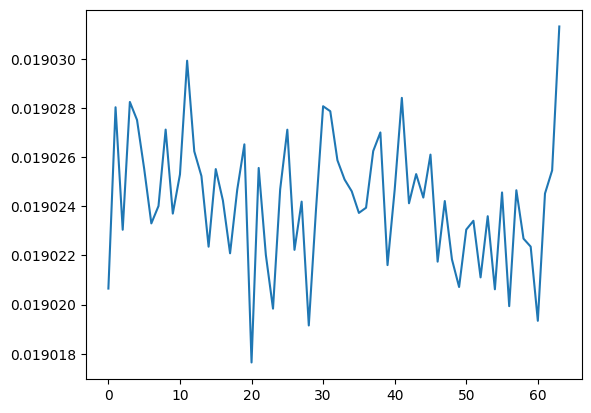

In [37]:
plt.plot(np.abs(results))

In [25]:
len(results)

64